In [1]:
import pandas as pd
import numpy as np
import os
import warnings
from collections import Counter
import seaborn as sns
import matplotlib.pylab as plt
import scipy
from datetime import datetime
from sklearn import feature_selection
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
import xgboost
import lightgbm
from imblearn.over_sampling import SMOTE,SMOTENC
from sklearn.metrics import make_scorer,roc_auc_score,accuracy_score,f1_score,roc_curve
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score,train_test_split,RandomizedSearchCV
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from vecstack import stacking
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
import pickle
import time

In [2]:
os.chdir('d:/')
plt.rcParams['figure.figsize']=(12,10)
warnings.filterwarnings(category=FutureWarning,action='ignore')
np.set_printoptions(precision=10,suppress=True)

# get data ready and exam the data

In [3]:
df=pd.read_csv('Fraud_data.csv')
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [192]:
# df[:50].drop(columns='class').to_csv('c:/users/lzc/desktop/slalom/test.csv',index=False)#create test case

In [7]:
df.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

In [5]:
df.shape

(151112, 11)

In [4]:
df.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [5]:
geo=pd.read_csv('IpAddress_to_Country.csv')
geo.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [5]:
geo.shape

(138846, 3)

In [9]:
geo.sort_values('lower_bound_ip_address',ascending=True,inplace=True)

In [ ]:
geo.head()

# data integration (map ID to Country)

In [6]:
#groud truth which cost O(N^2)

# res=[]
# for item in test_ip:
#     print(item)
#     for line in geo.iterrows():
#         if item > line[1][0] and item < line[1][1]:
#             res.append(line[1][2])
#             break
#     res.append(np.nan)
            

In [46]:
# if we lookup geo_merged data set every time for each IP in the df, then the time complexity will be O(N^2) (O(MN))
# so I first sort the IP in df O(MlogM), and iterate geo_merged for on time O(N)

In [7]:
IP_col=df['ip_address']

In [8]:
IP_col=IP_col.sort_values(ascending=True)

In [9]:
def map_algorithm(sort_list,sort_interval):
    """
    this algorithm use the concept of dynamic programming,
    it will iterate over the sort_list one time, for each item, it will iterate over the sort_interval.
    But the tricky part is that this algorithm will only iterate over sort_interval for only one time. once the 
    item in sort_list is larger than the upper bound of current interval,
    the algorithm will discard this interval and process to the next one.
    
    ###############################
    parameter
    
    sort_list:
    sorted list of ip_address
    
    sort_interval:
    dataframe which contain lower and upper bound of ip address as well as a country columns
    make sure to sort dataframe by lower bound ip address first
    """
    j=0
    res=[]
    
    for i in range(len(sort_list)):
        cur_interval=[sort_interval['lower_bound_ip_address'][j],sort_interval['upper_bound_ip_address'][j]]
        cur_country=sort_interval['country'][j]
#         print(sort_list[i],cur_interval)
        
        while j<len(sort_interval):
            cur_interval=[sort_interval['lower_bound_ip_address'][j],sort_interval['upper_bound_ip_address'][j]]
            cur_country=sort_interval['country'][j]
            if sort_list[i]<cur_interval[0]:
                res.append(np.nan)
                break
            elif sort_list[i]>=cur_interval[0] and sort_list[i]<=cur_interval[1]:
                res.append(cur_country)
                break
            elif sort_list[i]>cur_interval[1]:
                j+=1
        if j>=len(sort_interval) :#this is the early stop method, once the algorithm reach the last interval, then the 
                                  #following data in sort_list will be nan
            break
    res+=[np.nan]*(len(sort_list)-len(res))
    return res


In [10]:
res=map_algorithm(np.array(IP_col),geo)

In [11]:
IP_Country=pd.DataFrame({'IP':IP_col,'Country':res})

In [12]:
df=pd.merge(df,IP_Country,left_index=True,right_index=True).drop(columns='ip_address')

In [13]:
df.head(15)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,class,IP,Country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,0,7.327584e+08,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,0,3.503114e+08,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,1,2.621474e+09,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,0,3.840542e+09,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,0,4.155831e+08,United States
5,159135,2015-05-21 06:03:03,2015-07-09 08:05:14,42,ALEYXFXINSXLZ,Ads,Chrome,M,18,0,2.809315e+09,Canada
6,50116,2015-08-01 22:40:52,2015-08-27 03:37:57,11,IWKVZHJOCLPUR,Ads,Chrome,F,19,0,3.987484e+09,NaN
7,360585,2015-04-06 07:35:45,2015-05-25 17:21:14,27,HPUCUYLMJBYFW,Ads,Opera,M,34,0,1.692459e+09,United States
8,159045,2015-04-21 23:38:34,2015-06-02 14:01:54,30,ILXYDOZIHOOHT,SEO,IE,F,43,0,3.719094e+09,China
9,182338,2015-01-25 17:49:49,2015-03-23 23:05:42,62,NRFFPPHZYFUVC,Ads,IE,M,31,0,3.416747e+08,United States


#### random check

In [14]:
country_estimate=df['Country']
IP=df['IP']

In [15]:
def random_check(index):
#     country_estimate=df['Country'][index]
    item=df['IP'][index]
    for line in geo.iterrows():
        if item > line[1][0] and item < line[1][1]:
            return line[1][2]
    return np.nan

In [16]:
index_test=random.sample(list(range(len(df))),10)
for i in index_test:
    try:
        assert random_check(i) is df['Country'][i]
        print('index {} pass test case!'.format(i))
    except:
        print('index {} not pass test case!'.format(i))

index 28611 pass test case!
index 68413 pass test case!
index 89696 pass test case!
index 7386 pass test case!
index 25008 pass test case!
index 112937 pass test case!
index 118420 pass test case!
index 19373 pass test case!
index 70545 pass test case!
index 55326 pass test case!


#### impute the missing

In [17]:
df['Country'].fillna('Unknow',inplace=True)

In [22]:
df.groupby('Country')['class'].mean().sort_values()

Country
Kyrgyzstan                          0.000000
Maldives                            0.000000
Madagascar                          0.000000
Macau                               0.000000
Liechtenstein                       0.000000
Lesotho                             0.000000
Lao People's Democratic Republic    0.000000
Zambia                              0.000000
Jordan                              0.000000
Jamaica                             0.000000
Monaco                              0.000000
Iraq                                0.000000
Guam                                0.000000
Guadeloupe                          0.000000
Gibraltar                           0.000000
Ghana                               0.000000
Gambia                              0.000000
Gabon                               0.000000
Fiji                                0.000000
Faroe Islands                       0.000000
Ethiopia                            0.000000
Haiti                               0.000000
Mo

# EDA

Text(0.5, 1.0, 'Class Count')

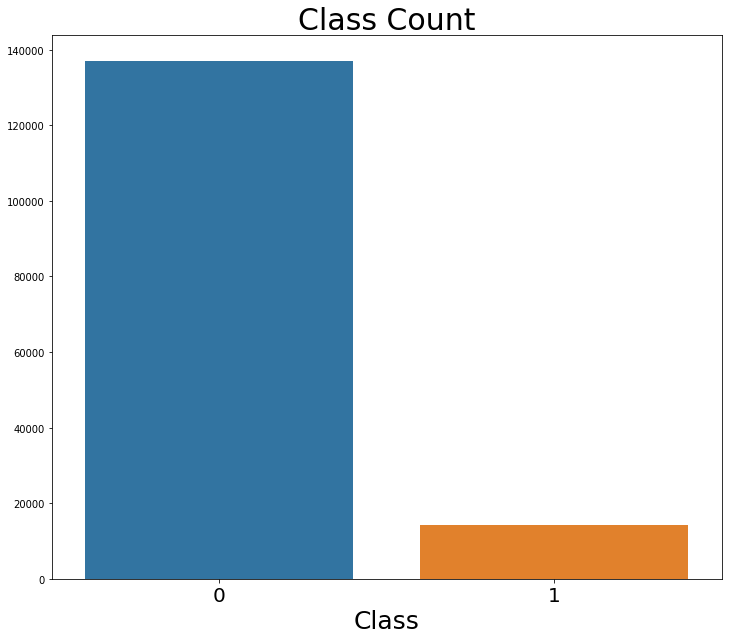

In [23]:
#exam the class, class 0 is the highest
fig,aes=plt.subplots()
C=Counter(df['class'])
sns.barplot(x=list(C.keys()),y=list(C.values()),ax=aes)
plt.xticks(fontsize=20)
plt.xlabel('Class',fontsize=25)
plt.title('Class Count',fontsize=30)

In [24]:
#exam missing value
def missing_rate(data):
    length=data.shape[0]
    Boolean_data=pd.isnull(data)
    result=Boolean_data.apply(lambda x:x.sum()/length,0)
    result=result.sort_values(ascending=False)
    return result

In [25]:
#exam outlier
def index_outlier(data,count=True):
    Q1=data.quantile(0.25)
    Q3=data.quantile(0.75)
    IQR=Q3-Q1
    if count:
        return len(np.nonzero(data.apply(lambda x: x>Q3+1.5*IQR or x<Q1-1.5*IQR))[0])
    else:
        return np.nonzero(data.apply(lambda x: x>Q3+1.5*IQR or x<Q1-1.5*IQR))[0]

In [26]:
missing_rate(df)

Country           0.0
IP                0.0
class             0.0
age               0.0
sex               0.0
browser           0.0
source            0.0
device_id         0.0
purchase_value    0.0
purchase_time     0.0
signup_time       0.0
user_id           0.0
dtype: float64

### datetime

In [4]:
# signup_time
# purchase_time
def transform_date(x):
    if not pd.isnull(x):
        return datetime.strptime(x,'%Y-%m-%d %H:%M:%S')
    else:
        return x

In [5]:
df['signup_time']=df['signup_time'].apply(lambda x:transform_date(x))

In [6]:
df['purchase_time']=df['purchase_time'].apply(lambda x:transform_date(x))

In [7]:
df['sinup_purchase_diff_hour']=(df['purchase_time']-df['signup_time']).apply(lambda x:x.total_seconds()/3600)

In [9]:
df.groupby('class')['sinup_purchase_diff_hour'].mean()

class
0    1441.994052
1     673.289542
Name: sinup_purchase_diff_hour, dtype: float64

In [22]:
#add weekend
# 5 6 are weekend
df['signup_time_weekday']=df['signup_time'].apply(lambda x:x.weekday())
df['signup_time_is_weekday']=df['signup_time_weekday'].apply(lambda x:1 if x==5 or x==6 else 0)

In [23]:
#add weekend
# 5 6 are weekend
df['purchase_time_weekday']=df['purchase_time'].apply(lambda x:x.weekday())
df['purchase_time_is_weekday']=df['purchase_time_weekday'].apply(lambda x:1 if x==5 or x==6 else 0)

In [24]:
df['signup_time_hour']=df['signup_time'].apply(lambda x:x.hour)
df['purchase_time_hour']=df['purchase_time'].apply(lambda x:x.hour)

In [25]:
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,class,IP,Country,sinup_purchase_diff_hour,signup_time_weekday,signup_time_is_weekday,purchase_time_weekday,purchase_time_is_weekday,signup_time_hour,purchase_time_hour
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,0,7.327584e+08,Japan,1251.856111,1,0,5,1,22,2
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,0,3.503114e+08,United States,4.984444,6,1,0,0,20,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,1,2.621474e+09,United States,0.000278,3,0,3,0,18,18
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,0,3.840542e+09,Unknow,136.690278,1,0,0,0,21,13
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,0,4.155831e+08,United States,1211.516944,1,0,2,0,7,18


Text(0.5, 1.0, 'Number_pruchase_across_day')

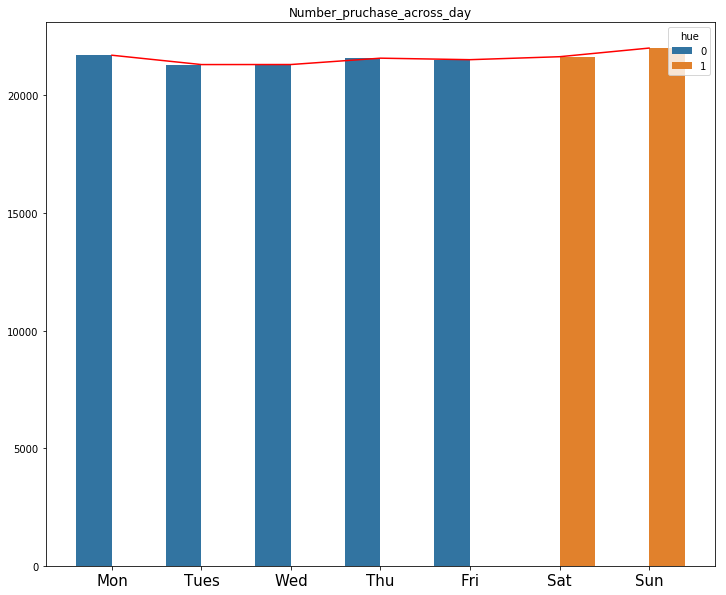

In [26]:
temp=df.groupby('purchase_time_weekday',as_index=False)['class'].count()
temp['hue']=temp['purchase_time_weekday'].apply(lambda x:1 if x==5 or x==6 else 0)
fig,aes=plt.subplots()
sns.barplot(x=temp['purchase_time_weekday'].values,
            y=temp['class'].values,ax=aes,hue=temp['hue'],
               )
aes.set_xticklabels(['Mon','Tues','Wed','Thu','Fri','Sat','Sun'])
plt.xticks(fontsize=15)
plt.plot(temp['class'].values,'red')
plt.title('Number_pruchase_across_day')
# plt.legend([''])

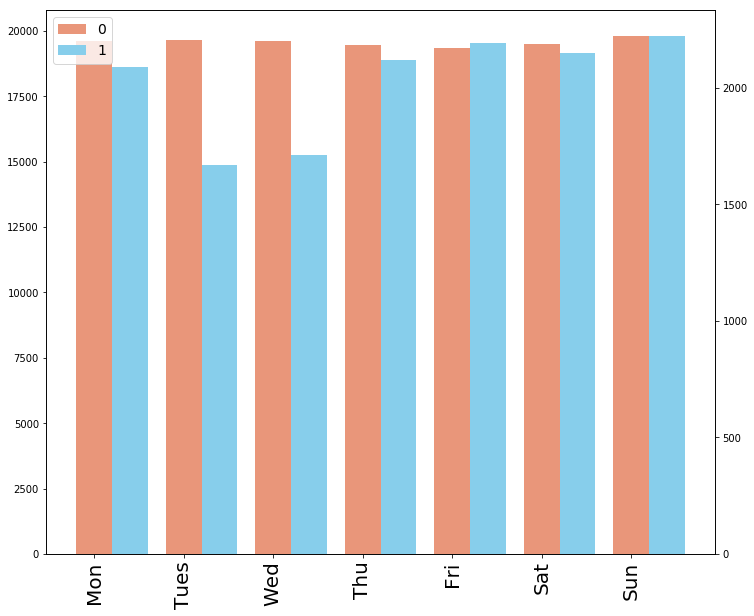

In [27]:
temp=df.groupby(['purchase_time_weekday','class'],as_index=False)['source'].count()
# temp.reset_index(level=0)
temp1=temp[temp['class']==0]
temp2=temp[temp['class']==1]
index=temp1['purchase_time_weekday']
y1=temp1['source']
y2=temp2['source']
bar_width=0.4
# plt.pyplot.subplots()
# import matplotlib.pyplot as plt
fig,aes=plt.subplots()
a=aes.bar(index,y1,width=bar_width,color='darksalmon')
plt.xticks(fontsize=20,rotation=90)
aes1=aes.twinx()
b=aes1.bar(index+bar_width,y2,width=0.4,color='skyblue')
aes1.set_xticks(index)
# aes1.set_xticklabels(temp.index)
aes.set_xticklabels(['Mon','Tues','Wed','Thu','Fri','Sat','Sun'])
plt.legend([a[0],b[0]],['0','1'],prop={'size':14})

Text(0.5, 1.0, 'fraud rate acroos day')

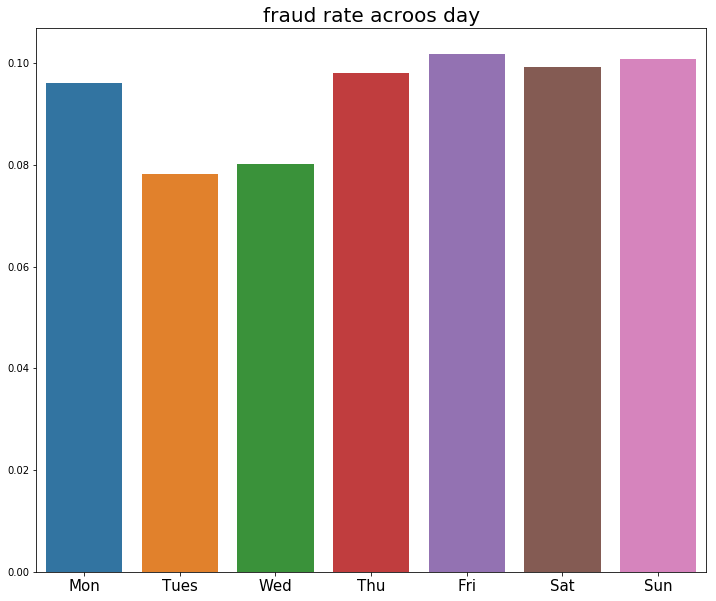

In [28]:
rate=np.array(temp2['source'])/(np.array(temp2['source'])+np.array(temp1['source']))
fig,aes=plt.subplots()
sns.barplot(x=list(range(len(rate))),
            y=rate,ax=aes,
               )
aes.set_xticklabels(['Mon','Tues','Wed','Thu','Fri','Sat','Sun'])
plt.xticks(fontsize=15)
# plt.plot(temp['class'].values,'red')
plt.title('fraud rate acroos day',fontsize=20)

Text(0.5, 1.0, 'Number_case_across_day')

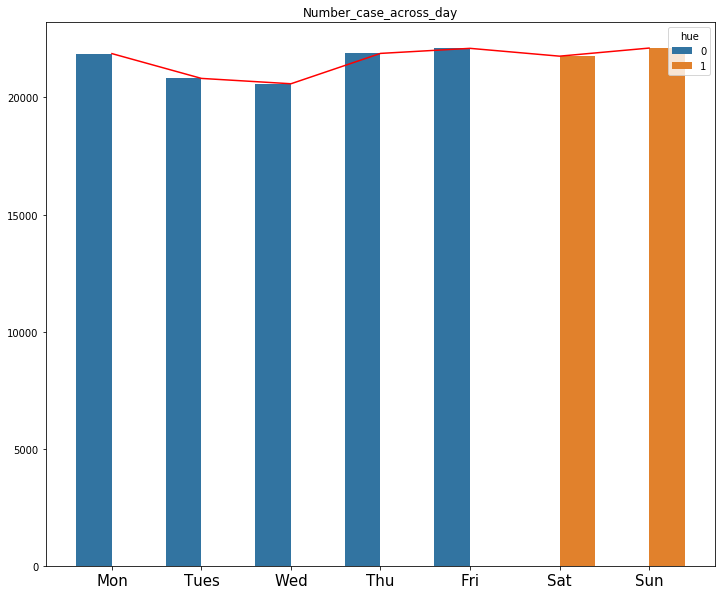

In [29]:
temp=df.groupby('signup_time_weekday',as_index=False)['class'].count()
temp['hue']=temp['signup_time_weekday'].apply(lambda x:1 if x==5 or x==6 else 0)
fig,aes=plt.subplots()
sns.barplot(x=temp['signup_time_weekday'].values,
            y=temp['class'].values,ax=aes,hue=temp['hue'],
               )
aes.set_xticklabels(['Mon','Tues','Wed','Thu','Fri','Sat','Sun'])
plt.xticks(fontsize=15)
plt.plot(temp['class'].values,'red')
plt.title('Number_case_across_day')

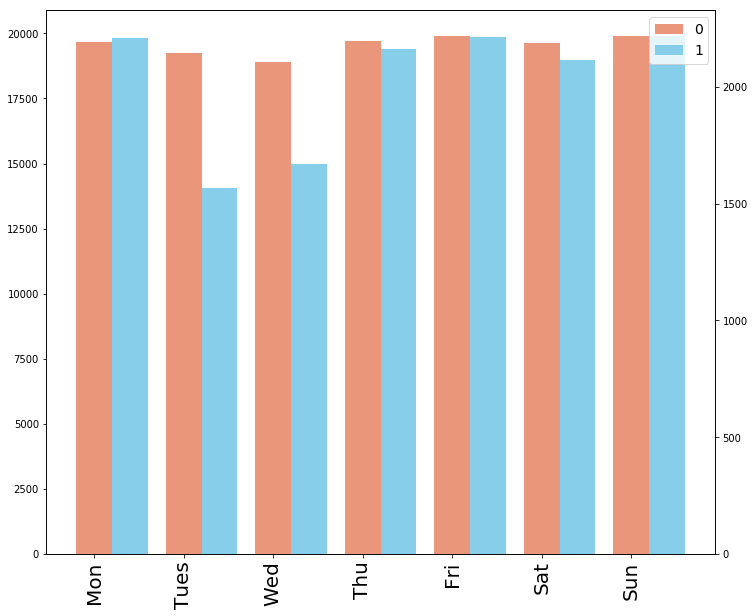

In [30]:
temp=df.groupby(['signup_time_weekday','class'],as_index=False)['source'].count()
# temp.reset_index(level=0)
temp1=temp[temp['class']==0]
temp2=temp[temp['class']==1]
index=temp1['signup_time_weekday']
y1=temp1['source']
y2=temp2['source']
bar_width=0.4
# plt.pyplot.subplots()
# import matplotlib.pyplot as plt
fig,aes=plt.subplots()
a=aes.bar(index,y1,width=bar_width,color='darksalmon')
plt.xticks(fontsize=20,rotation=90)
aes1=aes.twinx()
b=aes1.bar(index+bar_width,y2,width=0.4,color='skyblue')
aes1.set_xticks(index)
# aes1.set_xticklabels(temp.index)
aes.set_xticklabels(['Mon','Tues','Wed','Thu','Fri','Sat','Sun'])
plt.legend([a[0],b[0]],['0','1'],prop={'size':14})

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12]),
 <a list of 7 Text yticklabel objects>)

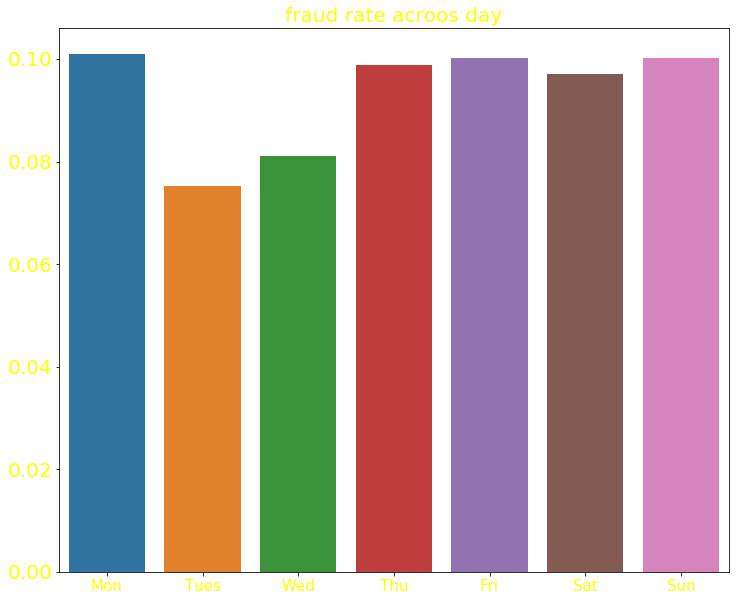

In [31]:
rate=np.array(temp2['source'])/(np.array(temp2['source'])+np.array(temp1['source']))
fig,aes=plt.subplots()
sns.barplot(x=list(range(len(rate))),
            y=rate,ax=aes,
               )
aes.set_xticklabels(['Mon','Tues','Wed','Thu','Fri','Sat','Sun'],color='yellow')
plt.xticks(fontsize=15)
# plt.plot(temp['class'].values,'red')
plt.title('fraud rate acroos day',fontsize=20,color='yellow')
plt.yticks(fontsize=20,color='yellow')

Text(0.5, 1.0, 'Number_case_across_day')

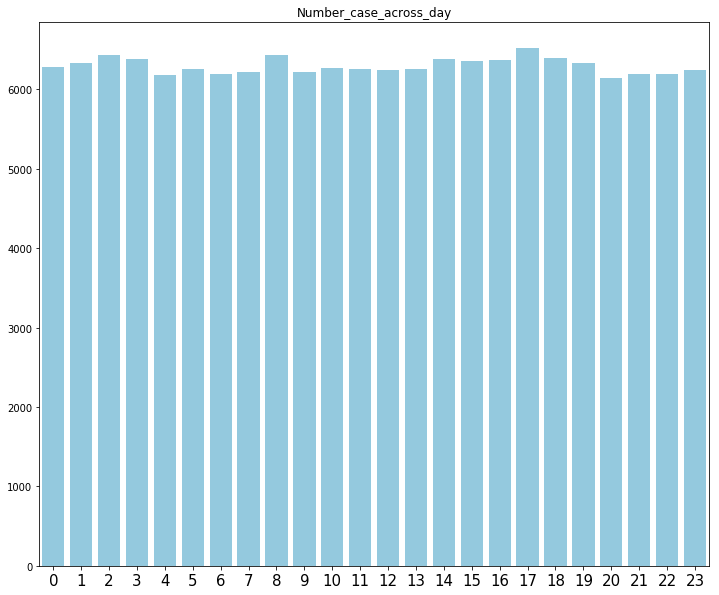

In [41]:
#accross the 24 hour
temp=df.groupby('signup_time_hour',as_index=False)['class'].count()
temp['hue']=temp['signup_time_hour'].apply(lambda x:1 if x==5 or x==6 else 0)
fig,aes=plt.subplots()
sns.barplot(x=temp['signup_time_hour'].values,
            y=temp['class'].values,ax=aes,color='skyblue'
               )
# aes.set_xticklabels(['Mon','Tues','Wed','Thu','Fri','Sat','Sun'])
plt.xticks(fontsize=15)
# plt.plot(temp['class'].values,'red')
plt.title('Number_case_across_day')

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14]),
 <a list of 8 Text yticklabel objects>)

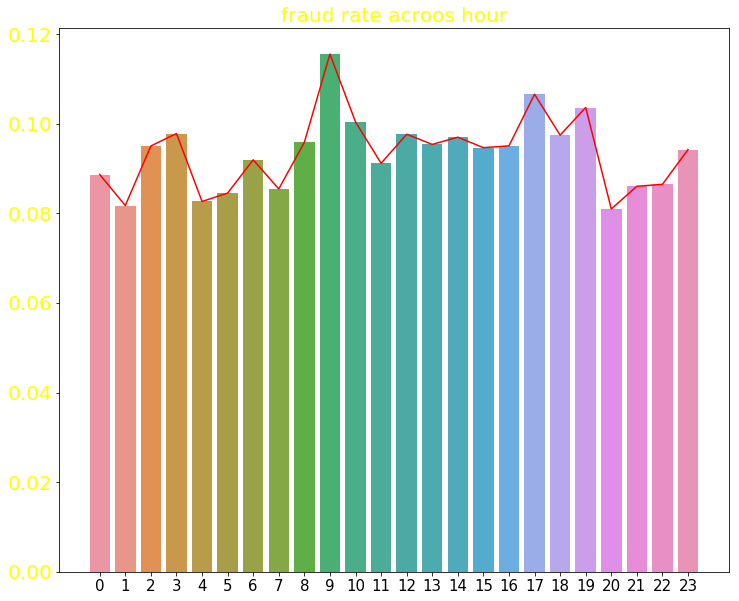

In [42]:
temp=df.groupby(['signup_time_hour','class'],as_index=False)['source'].count()
# temp.reset_index(level=0)
temp1=temp[temp['class']==0]
temp2=temp[temp['class']==1]
rate=np.array(temp2['source'])/(np.array(temp2['source'])+np.array(temp1['source']))
fig,aes=plt.subplots()
sns.barplot(x=list(range(len(rate))),
            y=rate,ax=aes,
               )
# aes.set_xticklabels(['Mon','Tues','Wed','Thu','Fri','Sat','Sun'],color='yellow')
plt.xticks(fontsize=15)
plt.plot(rate,'red')
plt.title('fraud rate acroos hour',fontsize=20,color='yellow')
plt.yticks(fontsize=20,color='yellow')

Text(0.5, 1.0, 'Number_case_across_hour')

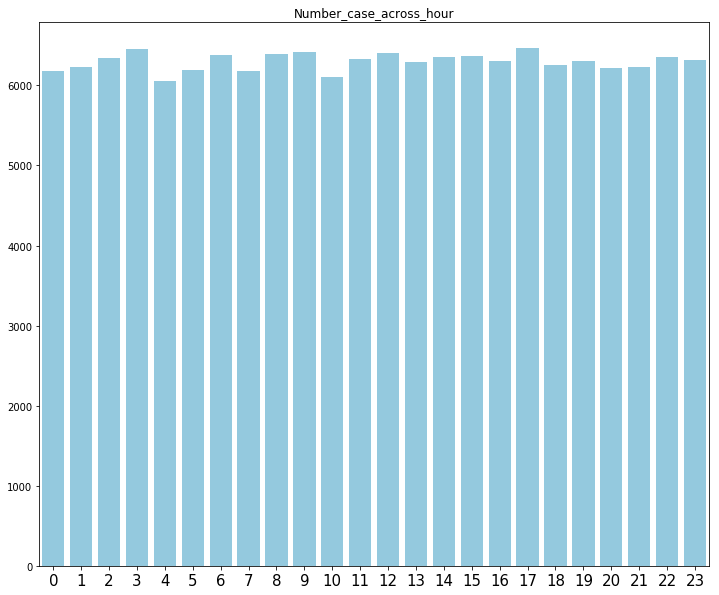

In [43]:
#accross the 24 hour
temp=df.groupby('purchase_time_hour',as_index=False)['class'].count()
temp['hue']=temp['purchase_time_hour'].apply(lambda x:1 if x==5 or x==6 else 0)
fig,aes=plt.subplots()
sns.barplot(x=temp['purchase_time_hour'].values,
            y=temp['class'].values,ax=aes,color='skyblue'
               )
# aes.set_xticklabels(['Mon','Tues','Wed','Thu','Fri','Sat','Sun'])
plt.xticks(fontsize=15)
# plt.plot(temp['class'].values,'red')
plt.title('Number_case_across_hour')

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12]),
 <a list of 7 Text yticklabel objects>)

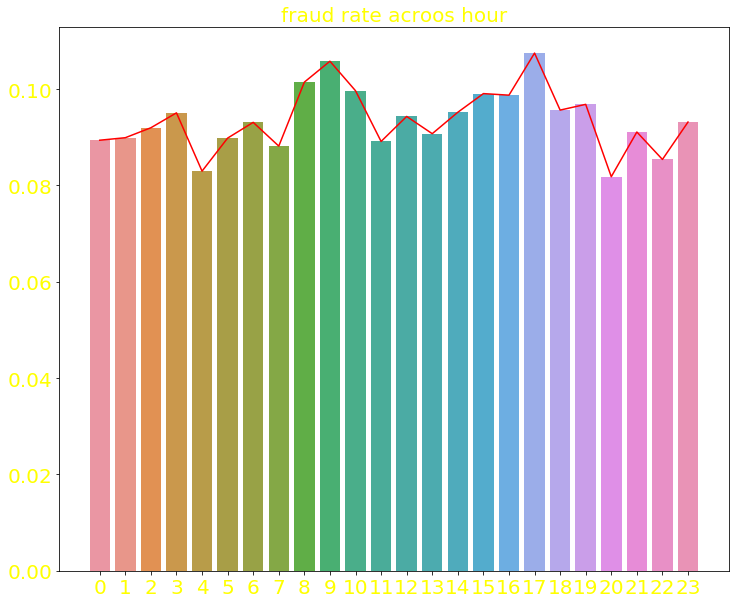

In [44]:
temp=df.groupby(['purchase_time_hour','class'],as_index=False)['source'].count()
# temp.reset_index(level=0)
temp1=temp[temp['class']==0]
temp2=temp[temp['class']==1]
rate=np.array(temp2['source'])/(np.array(temp2['source'])+np.array(temp1['source']))
fig,aes=plt.subplots()
sns.barplot(x=list(range(len(rate))),
            y=rate,ax=aes,
               )
# aes.set_xticklabels(['Mon','Tues','Wed','Thu','Fri','Sat','Sun'],color='yellow')
plt.xticks(fontsize=20,color='yellow')
plt.plot(rate,'red')
plt.title('fraud rate acroos hour',fontsize=20,color='yellow')
plt.yticks(fontsize=20,color='yellow')

### Source

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12]),
 <a list of 7 Text yticklabel objects>)

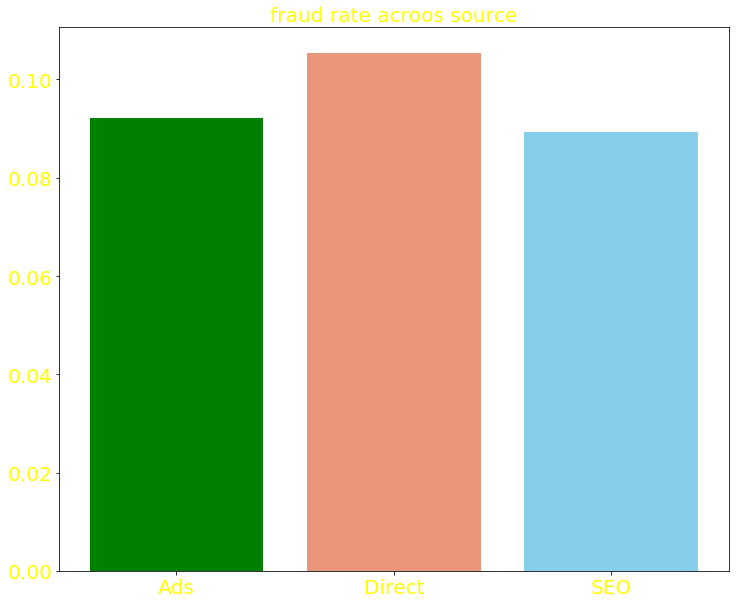

In [45]:
fig,aes=plt.subplots()
temp=df.groupby(['source']).apply(lambda x:len(x[x['class']==1])/len(x))
plt.bar(height=temp,x=temp.index,color=['g','darksalmon','skyblue'])
plt.xticks(fontsize=20,color='yellow')
# plt.plot(rate,'red')
plt.title('fraud rate acroos source',fontsize=20,color='yellow')
plt.yticks(fontsize=20,color='yellow')

### device

In [32]:
temp=df.groupby(['device_id','class'],as_index=False)['source'].count()
temp['number_fraud']=temp['class']*temp['source']
temp.head()
temp=temp.groupby('device_id',as_index=False)['number_fraud'].sum()
temp.head(15)

,device_id,number_fraud
0,AAALBGNHHVMKG,0
1,AAAWIHVCQELTP,0
2,AAAXJHWCLISKY,0
3,AAAXXOZJRZRAO,10
4,AABFGRPBQHWFQ,0
5,AABGCAPIYUWNC,0
6,AABJEESQPJHDQ,0
7,AABNLBQBKMWRG,0
8,AABOMYDURXEQT,0
9,AABOOVEJUXMKC,0


In [33]:
device_number={}
for line in temp.iterrows():
    if line[1][0] not in device_number:
        device_number[line[1][0]]=line[1][1]
    else:
        print('non possible')


In [34]:
def save_obj(obj, name ):
    with open( name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open( name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [35]:
save_obj(device_number,'device_dict')
device_number=load_obj('device_dict')

In [36]:
df['number_fraude']=df['device_id'].apply(lambda x:device_number[x])#add new feature

### Purchase value

(array([0.    , 0.0025, 0.005 , 0.0075, 0.01  , 0.0125, 0.015 , 0.0175,
        0.02  , 0.0225]), <a list of 10 Text yticklabel objects>)

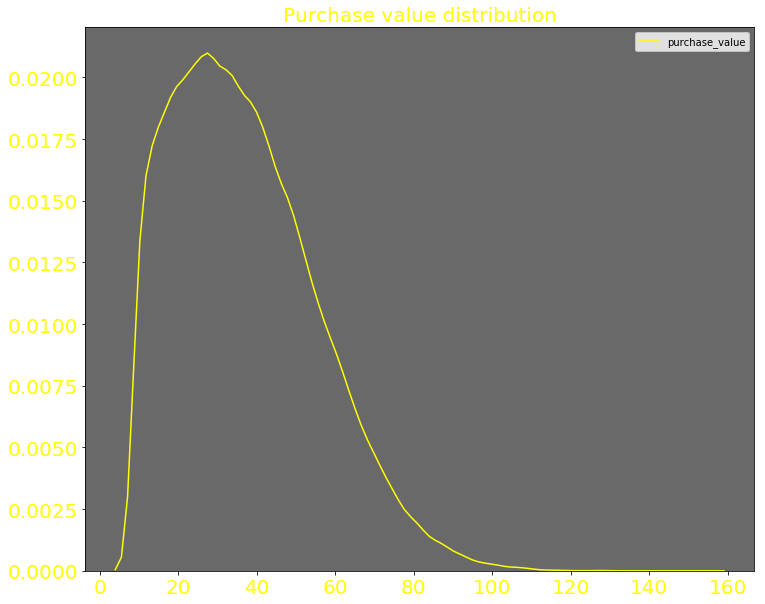

In [51]:
df['purchase_value'].describe()
sns.kdeplot(df['purchase_value'],color='yellow')
ax=plt.gca()
ax.set_facecolor('dimgrey')
plt.xticks(fontsize=20,color='yellow')
# plt.plot(rate,'red')
plt.title('Purchase value distribution',fontsize=20,color='yellow')
plt.yticks(fontsize=20,color='yellow')

### age

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05]),
 <a list of 6 Text yticklabel objects>)

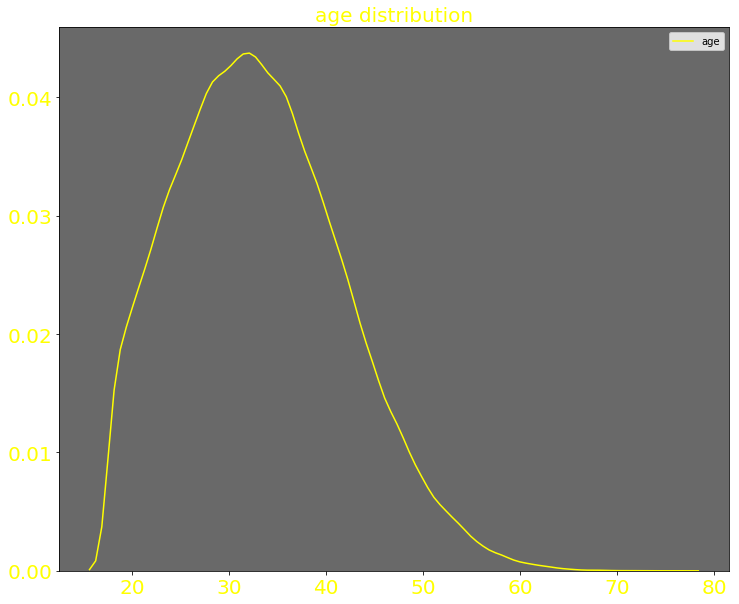

In [52]:
df['age'].describe()
sns.kdeplot(df['age'],color='yellow')
ax=plt.gca()
ax.set_facecolor('dimgrey')
plt.xticks(fontsize=20,color='yellow')
# plt.plot(rate,'red')
plt.title('age distribution',fontsize=20,color='yellow')
plt.yticks(fontsize=20,color='yellow')

# feature engineering and feature selection

In [53]:
missing_rate(df)

number_fraude               0.0
purchase_time_hour          0.0
signup_time                 0.0
purchase_time               0.0
purchase_value              0.0
device_id                   0.0
source                      0.0
browser                     0.0
sex                         0.0
age                         0.0
class                       0.0
IP                          0.0
Country                     0.0
sinup_purchase_diff_hour    0.0
signup_time_weekday         0.0
signup_time_is_weekday      0.0
purchase_time_weekday       0.0
purchase_time_is_weekday    0.0
signup_time_hour            0.0
user_id                     0.0
dtype: float64

In [37]:
df_train=df.copy()

In [38]:
df_train.drop(columns=['signup_time','purchase_time','user_id','IP','device_id'],inplace=True)

In [39]:
df_train.head()

,purchase_value,source,browser,sex,age,class,Country,sinup_purchase_diff_hour,signup_time_weekday,signup_time_is_weekday,purchase_time_weekday,purchase_time_is_weekday,signup_time_hour,purchase_time_hour,number_fraude
0,34,SEO,Chrome,M,39,0,Japan,1251.856111,1,0,5,1,22,2,0
1,16,Ads,Chrome,F,53,0,United States,4.984444,6,1,0,0,20,1,0
2,15,SEO,Opera,M,53,1,United States,0.000278,3,0,3,0,18,18,11
3,44,SEO,Safari,M,41,0,Unknow,136.690278,1,0,0,0,21,13,0
4,39,Ads,Safari,M,45,0,United States,1211.516944,1,0,2,0,7,18,0


In [57]:
#exam numeric value

def density_plot(data,col,class_label,class_columns_name):
    try:
        fig=plt.figure(figsize=(12,12))
        aes=fig.add_subplot(1,1,1)
        for i in class_label:
            sns.kdeplot(data.loc[(data[class_columns_name] == i).values, col].values, ax=aes, label='class '+str(i))
        handel = aes.get_legend_handles_labels()[0]
        label=aes.get_legend_handles_labels()[1]
        plt.title('columns {} Distribution'.format(col))
        plt.legend(handel, label,prop={'size': 12},loc=2)#location is upper left
    except Exception as e:
        print(e.message())
        pass

### Numercial columns

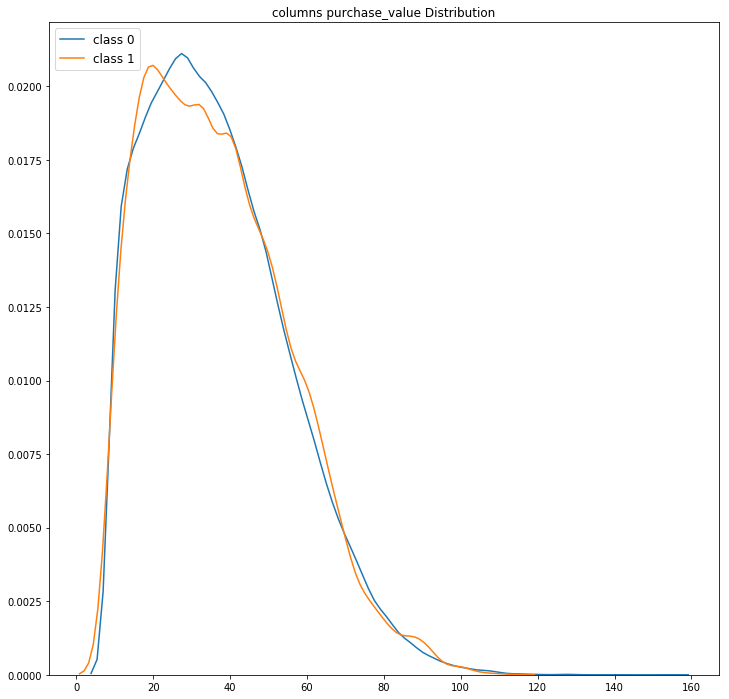

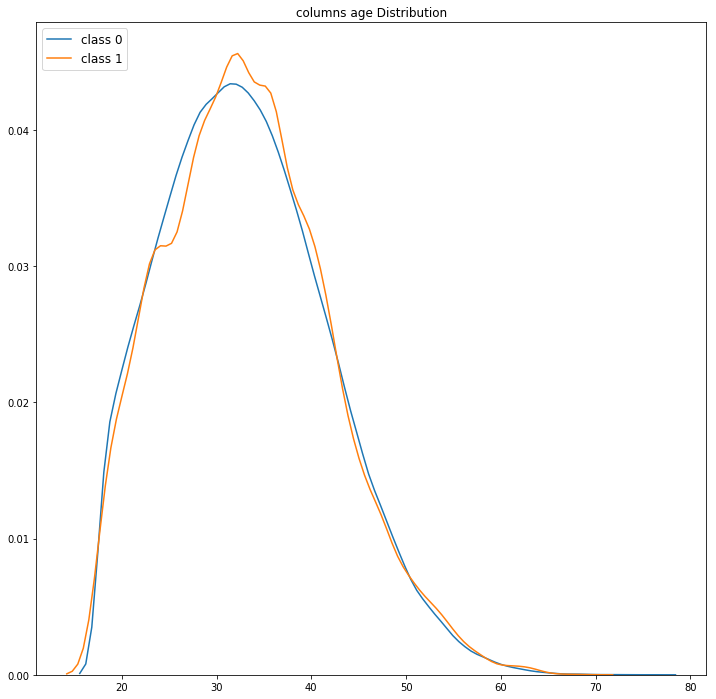

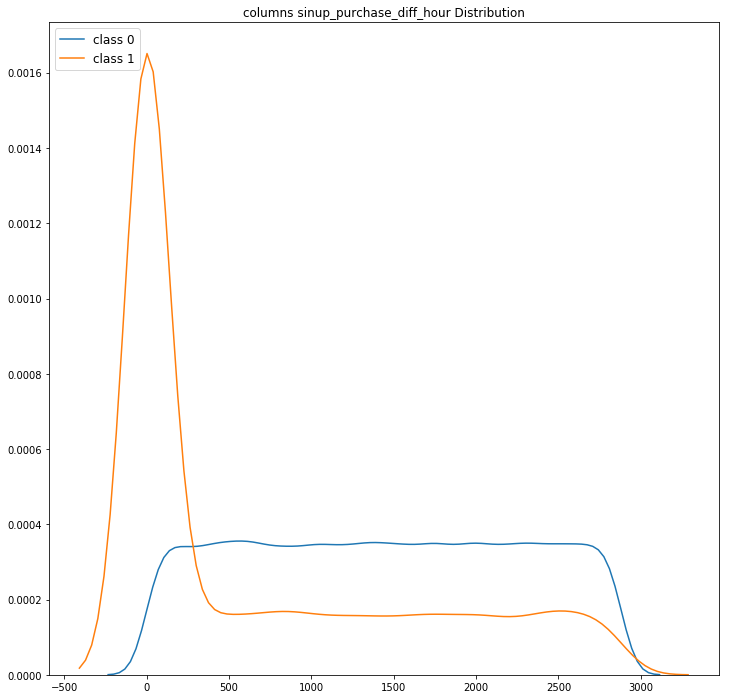

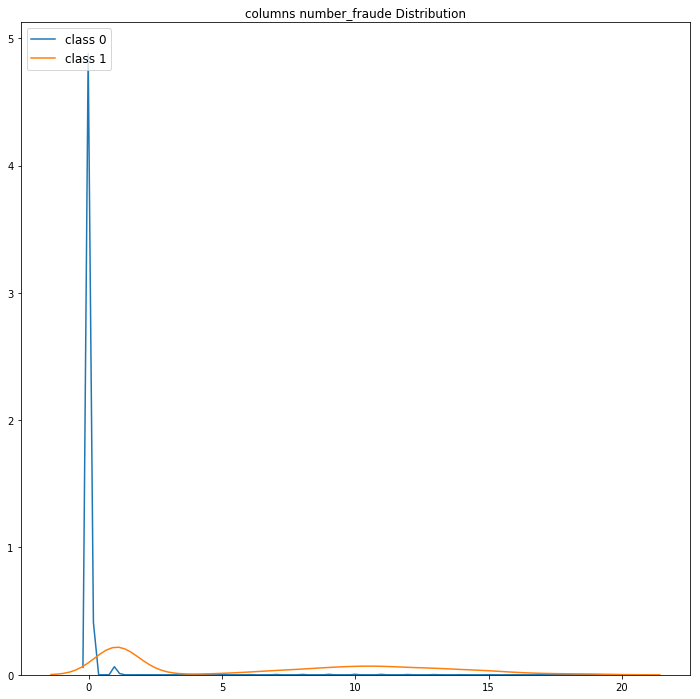

In [58]:
for col in ['purchase_value','age','sinup_purchase_diff_hour','number_fraude']:
    density_plot(df_train,col,[0,1],'class')

In [59]:
#anova
def f_anova(data,col,class_label,class_columns_name):
    arg=[data.loc[data[class_columns_name]==i,col] for i in class_label]
    f,p=scipy.stats.f_oneway(*arg)
    return f,p
#corr
def corv(data,col1,col2):
    return scipy.stats.stats.pearsonr(data[col1],data[col2])

In [61]:
for col in ['purchase_value','age','sinup_purchase_diff_hour','number_fraude']:
    print('{} vairable has ANOVA P value: {} \r\n has correlation :{}'.format(col,f_anova(df_train,col,[0,1],'class')[1],
                                                                                                         corv(df_train,col,'class')[0]))
    print('')

purchase_value vairable has ANOVA P value: 0.6943063556775206 
 has correlation :0.001011035007160815

age vairable has ANOVA P value: 0.01002992232683186 
 has correlation :0.00662357073396187

sinup_purchase_diff_hour vairable has ANOVA P value: 0.0 
 has correlation :-0.2578878676237365

number_fraude vairable has ANOVA P value: 0.0 
 has correlation :0.7119162700661177



### Category Columns

In [40]:
Cate_col=df_train.drop(columns=['purchase_value','age','sinup_purchase_diff_hour','number_fraude'])

In [41]:
for col in Cate_col.columns:
    if Cate_col[col].dtype=='O':
        LB=LabelEncoder()
        Cate_col[col]=LB.fit_transform(Cate_col[col])

In [64]:
# use MI to quantify the impact of each categorical variable on the class
feature_selection.mutual_info_classif(X=Cate_col.drop(columns='class'),y=Cate_col['class'],random_state=123)

array([0.0101199081, 0.0056751169, 0.0103625726, 0.0093298236,
       0.0039342943, 0.0014500089, 0.0048665997, 0.0024948026,
       0.0027566346, 0.0006708365])

# Model

In [42]:
KF=KFold(5,shuffle=True)
My_metric=make_scorer(roc_auc_score)

In [188]:
X_train=df_train.drop(columns='class')
Y_train=df_train['class']

In [191]:
for col in X_train.select_dtypes(include='O').columns:
    LB=LabelEncoder()
    LB.fit(X_train[col])
    X_train[col]=LB.transform(X_train[col])
    save_obj(LB,'{} LB'.format(col))

In [45]:
cate_indices=[1,2,3,5,7,8,9,10,11,12]
X_train.head()

,purchase_value,source,browser,sex,age,Country,sinup_purchase_diff_hour,signup_time_weekday,signup_time_is_weekday,purchase_time_weekday,purchase_time_is_weekday,signup_time_hour,purchase_time_hour,number_fraude
0,34,2,0,1,39,84,1251.856111,1,0,5,1,22,2,0
1,16,0,0,0,53,171,4.984444,6,1,0,0,20,1,0
2,15,2,3,1,53,171,0.000278,3,0,3,0,18,18,11
3,44,2,4,1,41,172,136.690278,1,0,0,0,21,13,0
4,39,0,4,1,45,171,1211.516944,1,0,2,0,7,18,0


### baseline model ::: LR

In [265]:
parameter={'C':np.arange(0.2,2.2,0.2),'max_iter':np.arange(100,300,50),'penalty':['l1','l2']}
LR=LogisticRegression(fit_intercept=True)
clf=GridSearchCV(LR,parameter,cv=5)
clf.fit(X_train,Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]), 'max_iter': array([100, 150, 200, 250]), 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [274]:
parameter={'C':np.arange(0.2,2.2,0.2),'max_iter':np.arange(100,300,50),'penalty':['l1','l2']}
LR=LogisticRegression(fit_intercept=True)
CLF=RandomizedSearchCV(cv=KF,scoring=My_metric,estimator=LR,n_iter=5,param_distributions=parameter)
# clf=GridSearchCV(LR,parameter,cv=5)
CLF.fit(X_train,Y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
          error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=5, n_jobs=None,
          param_distributions={'C': array([0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]), 'max_iter': array([100, 150, 200, 250]), 'penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=make_scorer(roc_auc_score),
          verbose=0)

In [277]:
CLF.best_params_

{'penalty': 'l1', 'max_iter': 100, 'C': 1.6}

In [278]:
LR=LogisticRegression(**CLF.best_params_)
cross_val_score(LR,X=X_train,y=Y_train,cv=KF,scoring=My_metric)

array([0.7656199341, 0.7738799523, 0.7590175477, 0.7664853329,
       0.7680672878])

## deal with unbalanced problem

In [46]:
SE=SMOTENC(categorical_features=cate_indices)
X_train_,Y_train_=SE.fit_resample(X_train,Y_train)

In [47]:
X_train_=pd.DataFrame(X_train_,columns=X_train.columns)

In [51]:
Y_train_=pd.DataFrame(data=Y_train_,columns=['class'])

In [52]:
X_train_.to_csv('x_train_.csv')
Y_train_.to_csv('Y_train_.csv')

In [128]:
X_train_=pd.read_csv('x_train_.csv',index_col=0)
Y_train_=pd.read_csv('Y_train_.csv',index_col=0)

In [129]:
Y_train_=Y_train_['class']

In [130]:
X_train_.drop(columns='number_fraude',inplace=True)

#### LR

In [116]:
LR=LogisticRegression(fit_intercept=True,**{'penalty': 'l1', 'max_iter': 100, 'C': 1.6})
cross_val_score(LR,X=X_train_,y=Y_train_,cv=KF,scoring=My_metric)

array([0.6901836631, 0.6952985264, 0.6941562565, 0.6917233146,
       0.6926384153])

In [98]:
LR=LogisticRegression(fit_intercept=True,**{'penalty': 'l1', 'max_iter': 100, 'C': 1.6})
cross_val_score(LR,X=X_train_,y=Y_train_,cv=KF)


array([0.6907365155, 0.6908825408, 0.6948744159, 0.6952577395,
       0.6916617991])

#### Random Forest

In [131]:
for train,test in KF.split(X_train_):
#     print(Y_train.iloc[list(test)])
    RF = RandomForestClassifier(bootstrap=True,max_depth=3,max_features='sqrt',
                                min_samples_leaf=2,min_samples_split=4,n_estimators=60)
    RF.fit(X=X_train_.iloc[list(train),:],y=Y_train_[list(train)])
    Y_pre=RF.predict_proba(X_train_.iloc[list(test)])
    print(roc_auc_score(Y_train_[list(test)],y_score=Y_pre[:,1]))

0.8621018109995382
0.8655477454818791
0.8543103720711446
0.856279227172881
0.8588805071541579


[('sinup_purchase_diff_hour', 0.7568607015315051), ('Country', 0.06837012885507322), ('signup_time_weekday', 0.05912631524822007), ('browser', 0.042304044028543715), ('age', 0.019905980100562458), ('purchase_time_weekday', 0.016283887985397455), ('signup_time_is_weekday', 0.00910551201333194), ('sex', 0.008205035587082795), ('purchase_time_hour', 0.005890859217918652), ('purchase_value', 0.0051096376746047), ('signup_time_hour', 0.004934774926783123), ('purchase_time_is_weekday', 0.0036579925261003366), ('source', 0.00024513030487639164)]


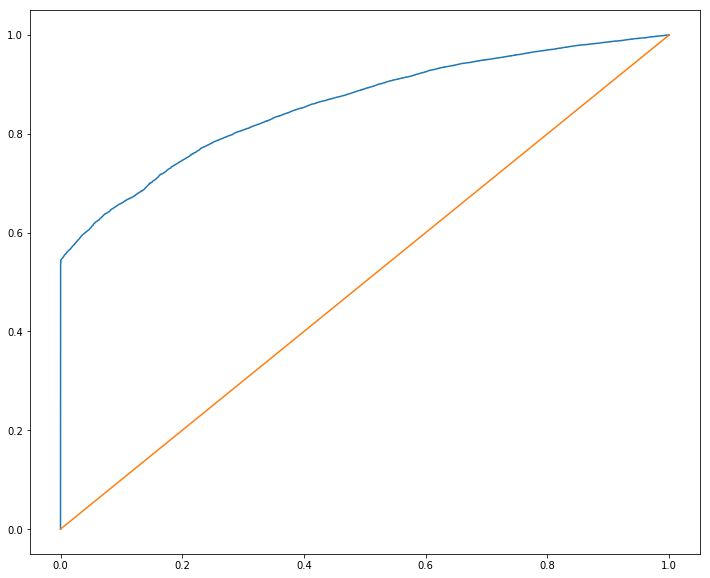

In [139]:
RF = RandomForestClassifier(bootstrap=True,max_depth=3,max_features='sqrt',
                                min_samples_leaf=2,min_samples_split=4,n_estimators=60)
X_train_temp, X_test_temp, Y_train_temp, Y_test_temp=train_test_split(X_train_,Y_train_,test_size=0.3,random_state=42)
RF.fit(X_test_temp,Y_test_temp)
Y_pre=RF.predict_proba(X_test_temp)

fpr, tpr, thresholds=roc_curve(Y_test_temp,Y_pre[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
print(sorted([(col,imp) for col,imp in zip(X_train_.columns,RF.feature_importances_)],key=lambda x:x[1],reverse=True))

#### GBDT

In [133]:
for train,test in KF.split(X_train_):
#     print(Y_train.iloc[list(test)])
    GB = GradientBoostingClassifier(max_depth=2,max_features='sqrt',
                                min_samples_leaf=2,min_samples_split=3,n_estimators=70)
    GB.fit(X=X_train_.iloc[list(train),:],y=Y_train_[list(train)])
    Y_pre=GB.predict_proba(X_train_.iloc[list(test),:])
    print(roc_auc_score(Y_train_[list(test)],y_score=Y_pre[:,1]))

0.8706290726238657
0.8660059203230339
0.8676350990190328
0.8696845071854787
0.874633554457453


[('sinup_purchase_diff_hour', 0.8670868801728605), ('Country', 0.07043974816873556), ('browser', 0.018167805708206763), ('age', 0.01391392673828603), ('signup_time_weekday', 0.01121072346350273), ('sex', 0.006082637125078144), ('purchase_value', 0.005554354616636674), ('purchase_time_weekday', 0.004474285323685687), ('signup_time_is_weekday', 0.0016138676266631798), ('purchase_time_is_weekday', 0.0010385666628793932), ('purchase_time_hour', 0.00022408425012565648), ('signup_time_hour', 0.00011569105245142217), ('source', 7.742909088815107e-05)]


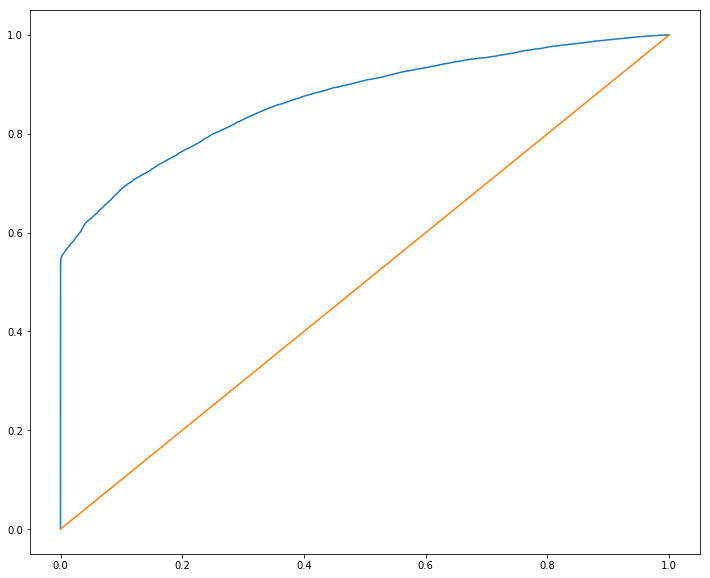

In [138]:
GB = GradientBoostingClassifier(max_depth=2,max_features='sqrt',
                                min_samples_leaf=2,min_samples_split=3,n_estimators=70)
X_train_temp, X_test_temp, Y_train_temp, Y_test_temp=train_test_split(X_train_,Y_train_,test_size=0.3,random_state=42)
GB.fit(X_test_temp,Y_test_temp)
Y_pre=GB.predict_proba(X_test_temp)

fpr, tpr, thresholds=roc_curve(Y_test_temp,Y_pre[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
print(sorted([(col,imp) for col,imp in zip(X_train_.columns,GB.feature_importances_)],key=lambda x:x[1],reverse=True))

#### Xgboost

In [141]:
for train,test in KF.split(X_train_):
#     print(Y_train.iloc[list(test)])
    XGB = xgboost.XGBClassifier(max_depth=2,max_features='auto',
                                min_samples_leaf=1,min_samples_split=2,n_estimators=100,reg_lambda=5)
    XGB.fit(X=X_train_.iloc[list(train),:],y=Y_train_[list(train)])
    Y_pre=XGB.predict_proba(X_train_.iloc[list(test),:])
    print(roc_auc_score(Y_train_[list(test)],y_score=Y_pre[:,1]))

0.8963575870497182
0.9003954069265929
0.896203467783566
0.900082328237382
0.9011028228008856


[('sinup_purchase_diff_hour', 0.8670868801728605), ('Country', 0.07043974816873556), ('browser', 0.018167805708206763), ('age', 0.01391392673828603), ('signup_time_weekday', 0.01121072346350273), ('sex', 0.006082637125078144), ('purchase_value', 0.005554354616636674), ('purchase_time_weekday', 0.004474285323685687), ('signup_time_is_weekday', 0.0016138676266631798), ('purchase_time_is_weekday', 0.0010385666628793932), ('purchase_time_hour', 0.00022408425012565648), ('signup_time_hour', 0.00011569105245142217), ('source', 7.742909088815107e-05)]


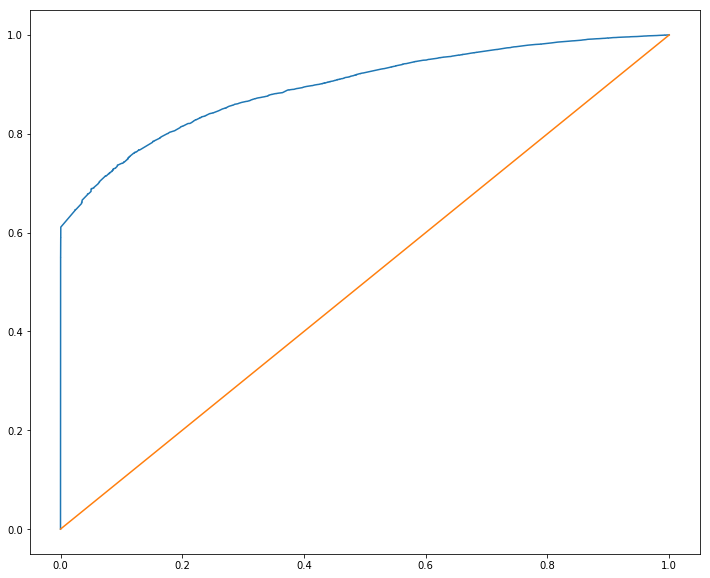

In [148]:
XGB = xgboost.XGBClassifier(max_depth=2,max_features='auto',
                                min_samples_leaf=1,min_samples_split=2,n_estimators=100,reg_lambda=5)
X_train_temp, X_test_temp, Y_train_temp, Y_test_temp=train_test_split(X_train_,Y_train_,test_size=0.3,random_state=42)
XGB.fit(X_test_temp,Y_test_temp)
Y_pre=XGB.predict_proba(X_test_temp)

fpr, tpr, thresholds=roc_curve(Y_test_temp,Y_pre[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
print(sorted([(col,imp) for col,imp in zip(X_train_.columns,XGB.feature_importances_)],key=lambda x:x[1],reverse=True))

#### gbm

In [146]:
for train,test in KF.split(X_train_):
#     print(Y_train.iloc[list(test)])
    LGB=lightgbm.LGBMClassifier(max_depth=2,max_features='auto',
                                min_samples_leaf=3,min_samples_split=2,n_estimators=100,reg_lambda=5)
    LGB.fit(X=X_train_.iloc[list(train),:],y=Y_train_[list(train)])
    Y_pre=LGB.predict_proba(X_train_.iloc[list(test),:])
    print(roc_auc_score(Y_train_[list(test)],y_score=Y_pre[:,1]))

0.8958649427171542
0.8978628763386189
0.8993271027321911
0.896970791349962
0.899250096288678


[('age', 75), ('sinup_purchase_diff_hour', 59), ('Country', 44), ('purchase_value', 23), ('browser', 20), ('signup_time_weekday', 10), ('sex', 7), ('signup_time_is_weekday', 5), ('purchase_time_weekday', 2), ('purchase_time_is_weekday', 1), ('source', 0), ('signup_time_hour', 0), ('purchase_time_hour', 0)]


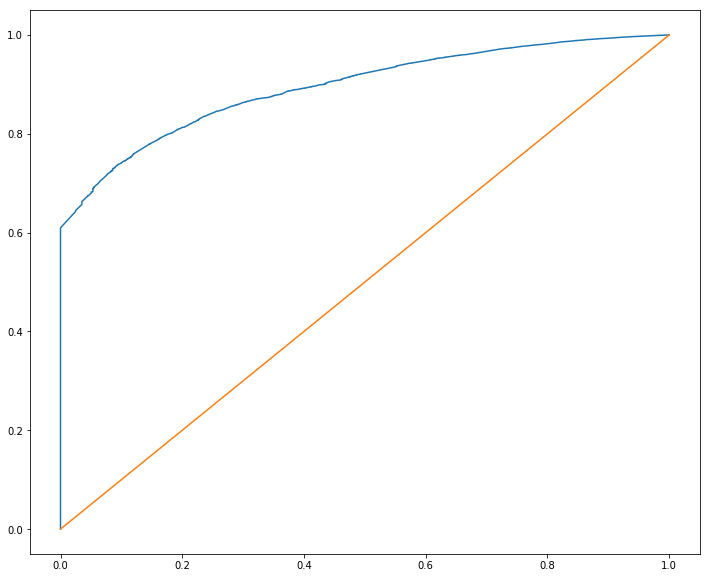

In [147]:
LGB=lightgbm.LGBMClassifier(max_depth=2,max_features='auto',
                                min_samples_leaf=3,min_samples_split=2,n_estimators=100,reg_lambda=5)
X_train_temp, X_test_temp, Y_train_temp, Y_test_temp=train_test_split(X_train_,Y_train_,test_size=0.3,random_state=42)
LGB.fit(X_test_temp,Y_test_temp)
Y_pre=LGB.predict_proba(X_test_temp)

fpr, tpr, thresholds=roc_curve(Y_test_temp,Y_pre[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
print(sorted([(col,imp) for col,imp in zip(X_train_.columns,LGB.feature_importances_)],key=lambda x:x[1],reverse=True))

### stacking

In [150]:
RF =  RandomForestClassifier(bootstrap=True,max_depth=3,max_features='sqrt',
                                min_samples_leaf=2,min_samples_split=4,n_estimators=60)
GB = GB = GradientBoostingClassifier(max_depth=2,max_features='sqrt',
                                min_samples_leaf=2,min_samples_split=3,n_estimators=70)
XGB = XGB = xgboost.XGBClassifier(max_depth=2,max_features='auto',
                                min_samples_leaf=1,min_samples_split=2,n_estimators=100,reg_lambda=5)
LGB=lightgbm.LGBMClassifier(max_depth=2,max_features='auto',
                                min_samples_leaf=3,min_samples_split=2,n_estimators=100,reg_lambda=5)
models=[RF,GB,XGB,LGB]
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(X_train_, Y_train_, test_size=0.2, random_state=20)
S_train,S_test=stacking(models,X_TRAIN,Y_TRAIN,X_TEST,regression=False,metric=roc_auc_score,verbose=2,n_folds=4)

task:         [classification]
n_classes:    [2]
metric:       [roc_auc_score]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [RandomForestClassifier]
    fold  0:  [0.76945902]
    fold  1:  [0.76914903]
    fold  2:  [0.76969437]
    fold  3:  [0.76663260]
    ----
    MEAN:     [0.76873375] + [0.00122842]
    FULL:     [0.76873675]

model  1:     [GradientBoostingClassifier]
    fold  0:  [0.78429767]
    fold  1:  [0.78618248]
    fold  2:  [0.78693736]
    fold  3:  [0.77893121]
    ----
    MEAN:     [0.78408718] + [0.00312818]
    FULL:     [0.78412436]

model  2:     [XGBClassifier]
    fold  0:  [0.81615032]
    fold  1:  [0.81368062]
    fold  2:  [0.82004225]
    fold  3:  [0.81724118]
    ----
    MEAN:     [0.81677859] + [0.00228351]
    FULL:     [0.81678515]

model  3:     [LGBMClassifier]
    fold  0:  [0.81778081]
    fold  1:  [0.81931647]
    fold  2:  [0.81554490]
    fold  3:  [0.81666868]
    ----
    MEAN:     [0.81732771] + [0.00139402]
    FULL: 

0.828557735635712


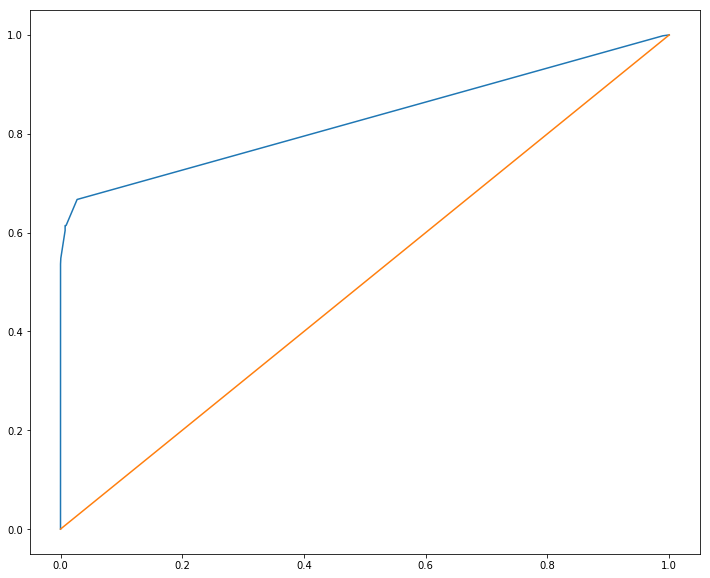

In [151]:
LGB=lightgbm.LGBMClassifier(max_depth=2,max_features='auto',
                                min_samples_leaf=3,min_samples_split=2,n_estimators=100,reg_lambda=5)
LGB.fit(S_train,Y_TRAIN)
Y_pre=LGB.predict_proba(S_test)
fpr, tpr, thresholds=roc_curve(Y_TEST,Y_pre[:,1])
plt.plot(fpr,tpr)
plt.plot([0,1],[0,1])
print(roc_auc_score(Y_TEST,Y_pre[:,1]))
# print(sorted([(col,imp) for col,imp in zip(X_train_.columns,LGB.feature_importances_)],key=lambda x:x[1],reverse=True))

In [184]:
RF = RandomForestClassifier(bootstrap=True,max_depth=3,max_features='sqrt',
                                min_samples_leaf=2,min_samples_split=4,n_estimators=60)
RF.fit(X=X_train_,y=Y_train_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=60, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [185]:
save_obj(RF,'model')

In [186]:
CLF=load_obj('model')

In [187]:
CLF.predict(X_train_)

array([0, 0, 1, ..., 1, 0, 0], dtype=int64)